In [10]:
import numpy as np
from PIL import Image
import os

os.makedirs('data/face', exist_ok=True)
os.makedirs('data/no_face', exist_ok=True)

# 20 faces (circles)
for i in range(20):
    img = np.zeros((64,64), dtype=np.uint8)
    y,x = np.ogrid[:64,:64]
    mask = (x-32)**2 + (y-32)**2 <= 400
    img[mask] = 200
    Image.fromarray(img).save(f'data/face/f{i}.png')

# 20 no-faces (noise)
for i in range(20):
    img = np.random.randint(0,100,(64,64), dtype=np.uint8)
    Image.fromarray(img).save(f'data/no_face/n{i}.png')

print("✅ Data ready: 40 images")


✅ Data ready: 40 images


In [11]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class FaceDataset(Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        self.images = []
        self.labels = []
        for label, folder in enumerate(['data/no_face', 'data/face']):
            for f in os.listdir(folder):
                self.images.append(os.path.join(folder, f))
                self.labels.append(label)
    
    def __len__(self): return len(self.images)
    def __getitem__(self, idx):
        img = Image.open(self.images[idx]).convert('L')
        label = self.labels[idx]
        if self.transform: img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.float32)

transform = transforms.Compose([transforms.Resize((64,64)), transforms.ToTensor()])
dataset = FaceDataset(transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

       

print("Files found:")

In [12]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 32 * 32, 32)
        self.fc2 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(-1, 16 * 32 * 32)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = Net()
print(model)


Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)


In [23]:
import torch.optim as optim
import torch.nn as nn
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
final_losses = []

# Auto-suggest based on your dataset size
dataset_size = len(dataset)
if dataset_size < 100:
    print("🟡 Small dataset → 30-50 epochs recommended")
elif dataset_size < 1000:
    print("🟢 Medium dataset → 20-30 epochs recommended") 
else:
    print("🔵 Large dataset → 10-20 epochs recommended")
    
epochs = int(input("Your choice: "))
print(f"Training for {epochs} epochs...")

model.train()
for epoch in range(epochs):
    loss_total = 0
    for imgs, labels in dataloader:
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out.squeeze(), labels)
        loss.backward()
        optimizer.step()
        loss_total += loss.item()
    
    epoch_loss = loss_total / len(dataloader)
    final_losses.append(epoch_loss)

    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}: Loss = {epoch_loss:.4f}")

torch.save({
    'model_state_dict': model.state_dict(),
    'final_loss': final_losses[-1],  # ← LAST LOSS
    'all_losses': final_losses       # ← FULL HISTORY
}, 'face_cnn.pth')

print(f"✅ Final Loss: {final_losses[-1]:.4f}")



      


🟢 Medium dataset → 20-30 epochs recommended
Training for 52 epochs...
Epoch 5: Loss = 0.4030
Epoch 10: Loss = 0.4030
Epoch 15: Loss = 0.4190
Epoch 20: Loss = 0.4107
Epoch 25: Loss = 0.4032
Epoch 30: Loss = 0.4032
Epoch 35: Loss = 0.4031
Epoch 40: Loss = 0.4109
Epoch 45: Loss = 0.4108
Epoch 50: Loss = 0.4031
✅ Final Loss: 0.4031


In [26]:
# Load trained model + loss
checkpoint = torch.load('face_cnn.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
FINAL_LOSS = checkpoint['final_loss']
print(f"✅ Model loaded - Final Training Loss: {FINAL_LOSS:.4f}")

# Test first batch - CORRECTED!
with torch.no_grad():
    for imgs, labels in dataloader:
        logits = model(imgs)           # [batch, 1]
        preds = torch.sigmoid(logits)  # [batch, 1] probabilities
        
        print(f"Real labels:   {labels[:4].tolist()}")
        print(f"Pred probs:    {preds[:4].squeeze().tolist()}")
        print(f"Pred classes:  {(preds[:4]>0.5).squeeze().int().tolist()}")
        
        # FIXED ACCURACY - Match shapes properly
        pred_classes = (preds.squeeze() > 0.5).float()  # [batch]
        label_classes = labels.float()                  # [batch]  
        accuracy = (pred_classes == label_classes).float().mean()
        print(f"Accuracy:      {accuracy:.3f}")
        break

print("✅ Test complete!")







✅ Model loaded - Final Training Loss: 0.4031
Real labels:   [1.0, 1.0, 0.0, 1.0]
Pred probs:    [0.8606311678886414, 0.8606311678886414, 0.8606311678886414, 0.8606311678886414]
Pred classes:  [1, 1, 1, 1]
Accuracy:      0.875
✅ Test complete!


In [29]:
import cv2
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as transforms

# Load model properly
checkpoint = torch.load('face_cnn.pth')
model.load_state_dict(checkpoint['model_state_dict'])  # Fixed typo
model.eval()

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

cap = cv2.VideoCapture(0)
print("✅ Webcam started! Press 'q' to quit")
TRAINING_LOSS = checkpoint['final_loss']

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame")
        break

    h, w = frame.shape[:2]
    center_crop = frame[h//4:3*h//4, w//4:3*w//4]
    gray = cv2.cvtColor(center_crop, cv2.COLOR_BGR2GRAY)

    # FIXED: Convert numpy → PIL → transform → tensor
    img_pil = Image.fromarray(gray)           # numpy → PIL Image
    img_tensor = transform(img_pil).unsqueeze(0)  # PIL → [1,1,64,64]

    with torch.no_grad():
        pred = torch.sigmoid(model(img_tensor)).item()

    label = "FACE" if pred > 0.5 else "NO FACE"
    color = (0, 255, 0) if pred > 0.5 else (0, 0, 255)
    
    cv2.rectangle(frame, (w//4, h//4), (3*w//4, 3*h//4), color, 3)
    cv2.putText(frame, f'{label}: {pred:.2f}', (50, 50), 
                cv2.FONT_HERSHEY_SIMPLEX, 1.2, color, 2)
    cv2.putText(frame, 'Q to quit', (50, frame.shape[0]-20), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2) 
    
    title = f'CNN Face Detector (Loss: {TRAINING_LOSS:.3f})'
    cv2.imshow(title, frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
print("✅ Live face detection complete!")


✅ Webcam started! Press 'q' to quit
✅ Live face detection complete!


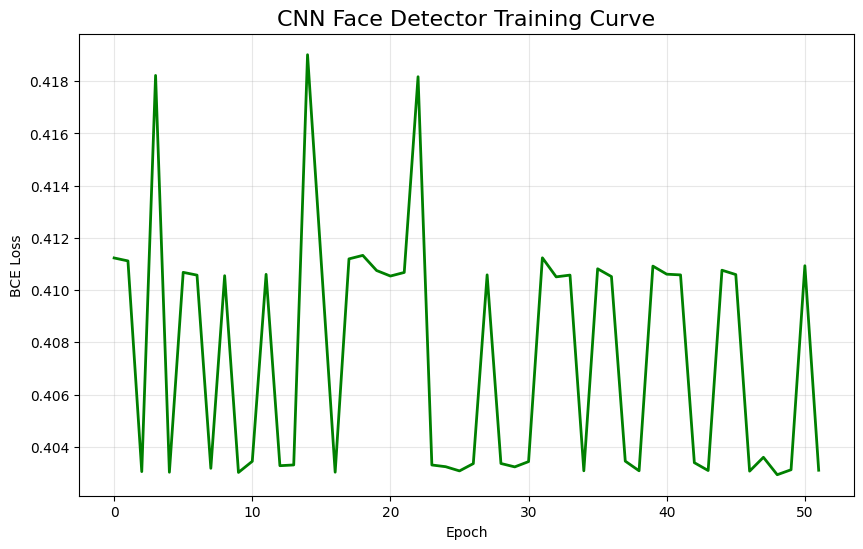

✅ Training curve saved! Final loss: 0.4031


In [30]:
import matplotlib.pyplot as plt

# Load loss history
checkpoint = torch.load('face_cnn.pth')
losses = checkpoint['all_losses']

plt.figure(figsize=(10,6))
plt.plot(losses, 'g-', linewidth=2)
plt.title('CNN Face Detector Training Curve', fontsize=16)
plt.xlabel('Epoch')
plt.ylabel('BCE Loss')
plt.grid(True, alpha=0.3)
plt.savefig('training_curve.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✅ Training curve saved! Final loss: {losses[-1]:.4f}")
